# Test on Controllability and Robustness in Knowledge Graph

- First "pretrain" on pure facts (context length/number of context examples of 1,2,3) 
- Then "finetune" on 1/3 facts, 1/3 counterfactual, 1/3 robustness (context length ranges from 1 to 3 randomly)
- Test on counterfactual w/ context length 1,2,3, robustness w/ context length 1,2,3

In [20]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [21]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers


## Config

In [22]:
args = argparse.Namespace(
    batch_size=64, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=1, n_heads=4, d_model=128, dff=128*4)

In [23]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Load Data

In [24]:
# how to load data and createe data loader
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)


In [25]:
# create vocab
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_map = {word: idx for idx, word in enumerate(vocab)}

In [26]:
# some examples from train__ds_tensor
for x in train_ds_tensor[:5]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 38, 52, 49, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N38 R2 N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 11, 50, 29, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N11 R0 N29 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 9, 54, 44, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N9 R4 N44 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 6, 53, 13, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N6 R3 N13 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 24, 50, 36, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N24 R0 N36 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [27]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[55, 56, 58, 16, 54, 32, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N16 R4 N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[56, 58, 16, 54, 32, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
</CTX> <QUERY> N16 R4 N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 2, 53, 36, 57, 26, 54, 21, 57, 8, 52, 39, 57, 56, 58, 26, 54, 21, 59]
<CTX> N2 R3 N36 <SEP> N26 R4 N21 <SEP> N8 R2 N39 <SEP> </CTX> <QUERY> N26 R4 N21 </QUERY>
TARGET
[2, 53, 36, 57, 26, 54, 21, 57, 8, 52, 39, 57, 56, 58, 26, 54, 21, 59, 60]
N2 R3 N36 <SEP> N26 R4 N21 <SEP> N8 R2 N39 <SEP> </CTX> <QUERY> N26 R4 N21 </QUERY> <EOS>
----------------------------------------------------------------------------------------------------

INPUT
[55, 56, 58, 31, 51, 35, 59, 60, 61, 61, 61, 61, 61, 6

### Create Val and Test Dataset & DataLoader

In [79]:

vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) 
seq_len = len(train_ds_tensor[0])
print('seq_len: ', seq_len)

# how to load data and createe data loader
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)


train_ds_fact_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')
train_ds_fact = LanguageModelTensorDataset(train_ds_fact_tensor)
train_dl_fact = torch.utils.data.DataLoader(train_ds_fact, batch_size=args.batch_size, shuffle=True)

test_ds_tensor_control_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_1.pt')
test_ds_control_1 = LanguageModelTensorDataset(test_ds_tensor_control_1)
test_dl_control_1_val = torch.utils.data.DataLoader(test_ds_control_1, batch_size=args.batch_size, shuffle=False)
test_ds_control_1_test_x = test_ds_tensor_control_1[:,:9]
test_ds_control_1_test_y = test_ds_tensor_control_1[:,9:]
test_ds_control_1_test = torch.utils.data.TensorDataset(test_ds_control_1_test_x, test_ds_control_1_test_y)
test_dl_control_1 = torch.utils.data.DataLoader(test_ds_control_1_test, batch_size=args.batch_size, shuffle=False)

test_ds_tensor_control_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_2.pt')
test_ds_control_2 = LanguageModelTensorDataset(test_ds_tensor_control_2)
test_dl_control_2_val = torch.utils.data.DataLoader(test_ds_control_2, batch_size=args.batch_size, shuffle=False)
test_ds_control_2_test_x = test_ds_tensor_control_2[:,:13]
test_ds_control_2_test_y = test_ds_tensor_control_2[:,13:]
test_ds_control_2_test = torch.utils.data.TensorDataset(test_ds_control_2_test_x, test_ds_control_2_test_y)
test_dl_control_2 = torch.utils.data.DataLoader(test_ds_control_2_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_control_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_3.pt')
test_ds_control_3 = LanguageModelTensorDataset(test_ds_tensor_control_3)
test_dl_control_3_val = torch.utils.data.DataLoader(test_ds_control_3, batch_size=args.batch_size, shuffle=False)
test_ds_control_3_test_x = test_ds_tensor_control_3[:,:17]
test_ds_control_3_test_y = test_ds_tensor_control_3[:,17:]
test_ds_control_3_test = torch.utils.data.TensorDataset(test_ds_control_3_test_x, test_ds_control_3_test_y)
test_dl_control_3 = torch.utils.data.DataLoader(test_ds_control_3_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_robust_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_1.pt')
test_ds_robust_1 = LanguageModelTensorDataset(test_ds_tensor_robust_1)
test_dl_robust_1_val = torch.utils.data.DataLoader(test_ds_robust_1, batch_size=args.batch_size, shuffle=False)
test_ds_robust_1_test_x = test_ds_tensor_robust_1[:,:9]
test_ds_robust_1_test_y = test_ds_tensor_robust_1[:,9:]
test_ds_robust_1_test = torch.utils.data.TensorDataset(test_ds_robust_1_test_x, test_ds_robust_1_test_y)
test_dl_robust_1 = torch.utils.data.DataLoader(test_ds_robust_1_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_robust_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_2.pt')
test_ds_robust_2 = LanguageModelTensorDataset(test_ds_tensor_robust_2)
test_dl_robust_2_val = torch.utils.data.DataLoader(test_ds_robust_2, batch_size=args.batch_size, shuffle=False)
test_ds_robust_2_test_x = test_ds_tensor_robust_2[:,:13]
test_ds_robust_2_test_y = test_ds_tensor_robust_2[:,13:]
test_ds_robust_2_test = torch.utils.data.TensorDataset(test_ds_robust_2_test_x, test_ds_robust_2_test_y)
test_dl_robust_2 = torch.utils.data.DataLoader(test_ds_robust_2_test, batch_size=args.batch_size, shuffle=False)




test_ds_tensor_robust_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_3.pt')
test_ds_robust_3 = LanguageModelTensorDataset(test_ds_tensor_robust_3)
test_dl_robust_3_val = torch.utils.data.DataLoader(test_ds_robust_3, batch_size=args.batch_size, shuffle=False)
test_ds_robust_3_test_x = test_ds_tensor_robust_3[:,:17]
test_ds_robust_3_test_y = test_ds_tensor_robust_3[:,17:]
test_ds_robust_3_test = torch.utils.data.TensorDataset(test_ds_robust_3_test_x, test_ds_robust_3_test_y)
test_dl_robust_3 = torch.utils.data.DataLoader(test_ds_control_3_test, batch_size=args.batch_size, shuffle=False)


print("Number of batches: ", len(train_dl))
    

vocab size:  63
seq_len:  20
Number of batches:  47


## Model

In [66]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        

        perplexity = torchmetrics.functional.text.perplexity(logits, y)
        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=True)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=True)

    def test_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]
    
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(generated_seq, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(generated_seq, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(generated_seq,y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, preds, targets):
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []   
            
             
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [67]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      8,064                  3.72%              True
│    │    └─Linear (weights): 3-1                                           8,127                  3.74%              True
│    └─Embedding (positional_embedder): 2-2                                 2,560                  1.18%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [68]:
lit_model = LitLanguageModel(model)

In [69]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
# multi validation dataloaders
validation_dataloaders = [test_dl_control_1_val, test_dl_control_2_val, test_dl_control_3_val, test_dl_robust_1_val, test_dl_robust_2_val, test_dl_robust_3_val]
trainer.fit(model=lit_model, train_dataloaders=train_dl_fact, val_dataloaders=validation_dataloaders)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/ruixiaowang/Desktop/Desktop - Ruixiao’s MacBook Air/Yale/Research/Robustness and Controllability/Controllability-and-Robustness/experiments/checkpoints exists and is not empty.

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 217 K 
----------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.868     Total estimated model params size (MB)


num decayed parameter tensors: 7, with 215,296 parameters
num non-decayed parameter tensors: 9, with 1,727 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The

Training: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 217 K 
----------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.868     Total estimated model params size (MB)


num decayed parameter tensors: 7, with 215,296 parameters
num non-decayed parameter tensors: 9, with 1,727 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


### "finetune" on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness


In [70]:
# finetune on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness

trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=validation_dataloaders)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 217 K 
----------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.868     Total estimated model params size (MB)


num decayed parameter tensors: 7, with 215,296 parameters
num non-decayed parameter tensors: 9, with 1,727 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

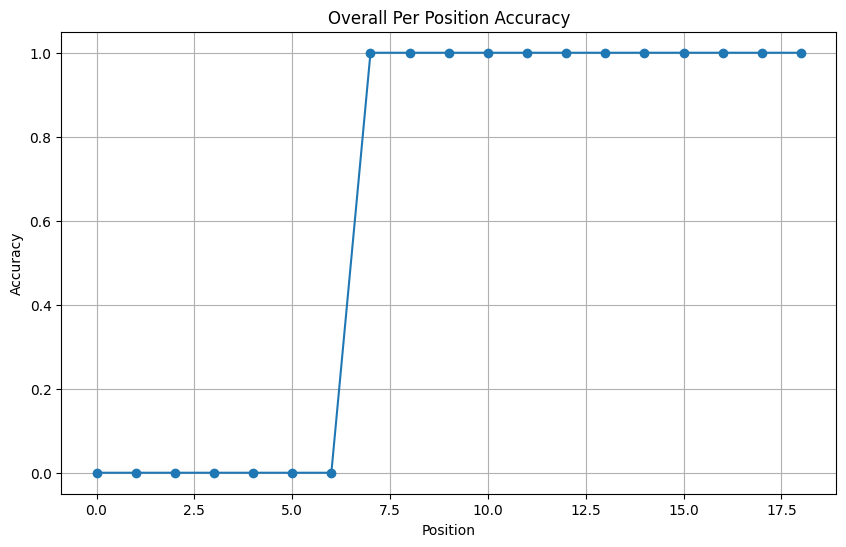

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.6315789222717285       │
│     test_overall_seq_acc      │              0.0              │
└───────────────────────────────┴───────────────────────────────┘

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.9369938969612122     │     1.660067081451416     │     2.265885829925537     │
│      val_perplexity       │    2.5539774894714355     │     5.264458656311035     │     9.648096084594727     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0332633256912231     │    1.4741437435150146     │    1.9589320421218872     │
│      val_perplexity       │     2.81107759475708      │     4.368774890899658     │     7.095625400543213     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_loss/dataloader_idx_0': 0.9369938969612122,
  'val_perplexity/dataloader_idx_0': 2.5539774894714355},
 {'val_loss/dataloader_idx_1': 1.660067081451416,
  'val_perplexity/dataloader_idx_1': 5.264458656311035},
 {'val_loss/dataloader_idx_2': 2.265885829925537,
  'val_perplexity/dataloader_idx_2': 9.648096084594727},
 {'val_loss/dataloader_idx_3': 1.0332633256912231,
  'val_perplexity/dataloader_idx_3': 2.81107759475708},
 {'val_loss/dataloader_idx_4': 1.4741437435150146,
  'val_perplexity/dataloader_idx_4': 4.368774890899658},
 {'val_loss/dataloader_idx_5': 1.9589320421218872,
  'val_perplexity/dataloader_idx_5': 7.095625400543213}]

In [71]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}

# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl_fact)
# model performance on the validation set
lit_model.mismatched_sequences.clear()
trainer.validate(model=lit_model, dataloaders=validation_dataloaders)
#mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on counterfactual context

In [85]:
def decode_sequence(seq, reverse_vocab_map):
    return ' '.join([reverse_vocab_map[idx] for idx in seq])

def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=3):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}\n")

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

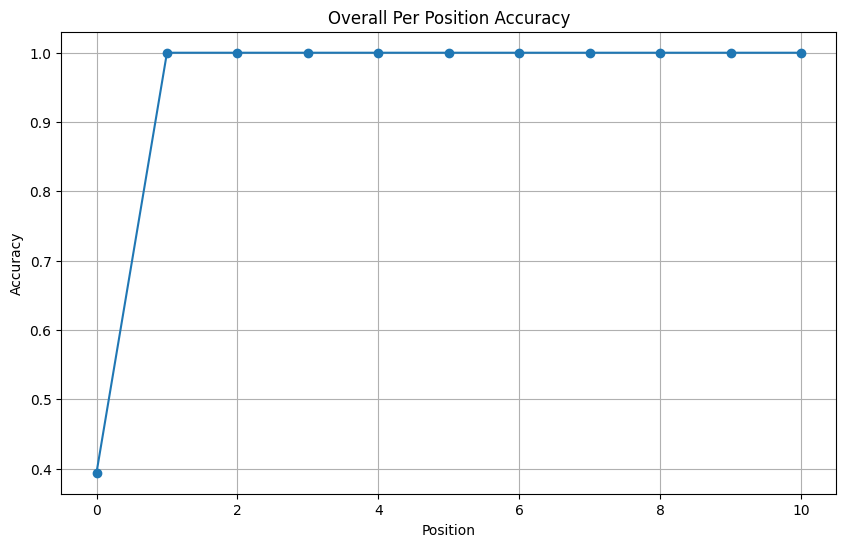

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9449218511581421       │
│     test_overall_seq_acc      │      0.3941406309604645       │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N3 R4 N27 <SEP> </CTX> <QUERY> N3 R4
Predicted: N20 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N27 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N4 R0 N3 <SEP> </CTX> <QUERY> N4 R0
Predicted: N20 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N34 R4 N10 <SEP> </CTX> <QUERY> N34 R4
Predicted: N43 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N10 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

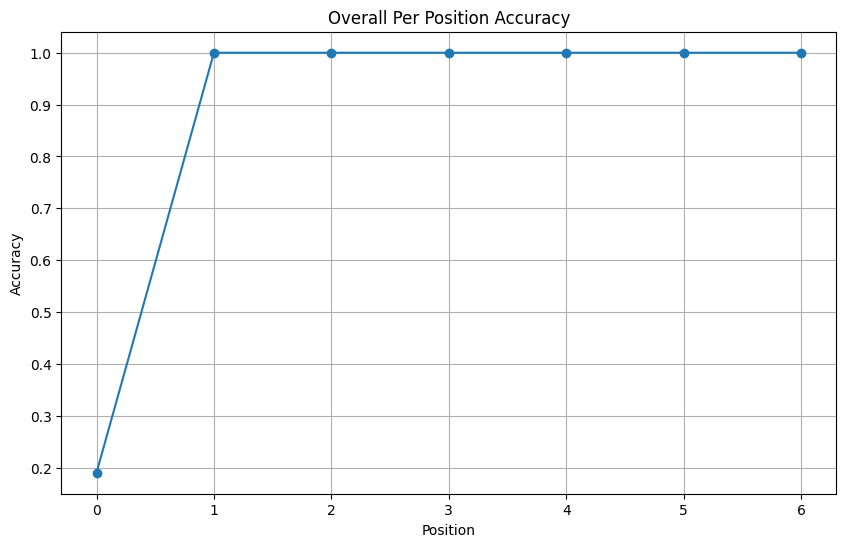

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.8842912912368774       │
│     test_overall_seq_acc      │      0.19003906846046448      │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N11 R0 N40 <SEP> N26 R0 N1 <SEP> </CTX> <QUERY> N26 R0
Predicted: N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N1 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N13 R0 N30 <SEP> N9 R3 N41 <SEP> </CTX> <QUERY> N13 R0
Predicted: N23 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N30 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N32 R4 N29 <SEP> N27 R3 N49 <SEP> </CTX> <QUERY> N32 R4
Predicted: N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N29 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

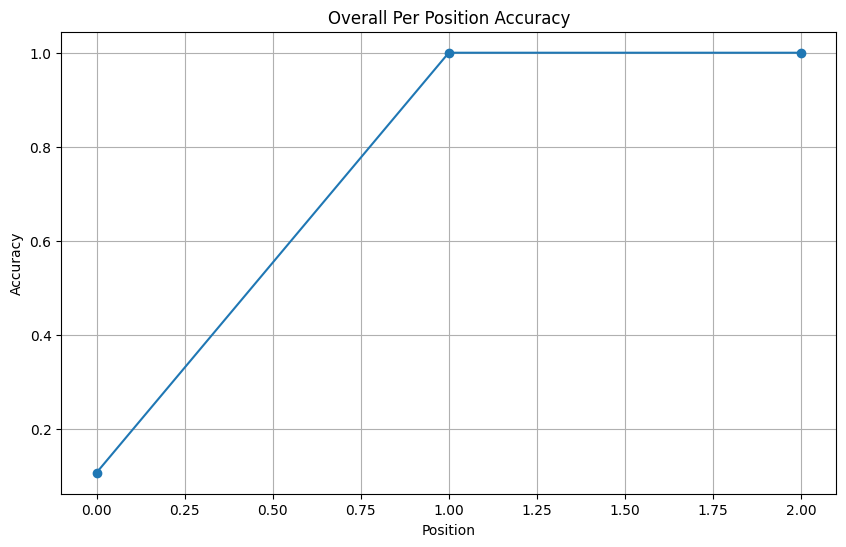

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.7024739384651184       │
│     test_overall_seq_acc      │          0.107421875          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N29 R4 N31 <SEP> N3 R0 N41 <SEP> N8 R2 N44 <SEP> </CTX> <QUERY> N3 R0
Predicted: N31 </QUERY> <EOS>
Target: N41 </QUERY> <EOS>

Input: <CTX> N14 R3 N15 <SEP> N29 R1 N44 <SEP> N47 R4 N44 <SEP> </CTX> <QUERY> N47 R4
Predicted: N30 </QUERY> <EOS>
Target: N44 </QUERY> <EOS>

Input: <CTX> N15 R4 N30 <SEP> N8 R2 N39 <SEP> N8 R3 N7 <SEP> </CTX> <QUERY> N8 R3
Predicted: N4 </QUERY> <EOS>
Target: N7 </QUERY> <EOS>



In [86]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on Robustness 

Testing: |          | 0/? [00:00<?, ?it/s]

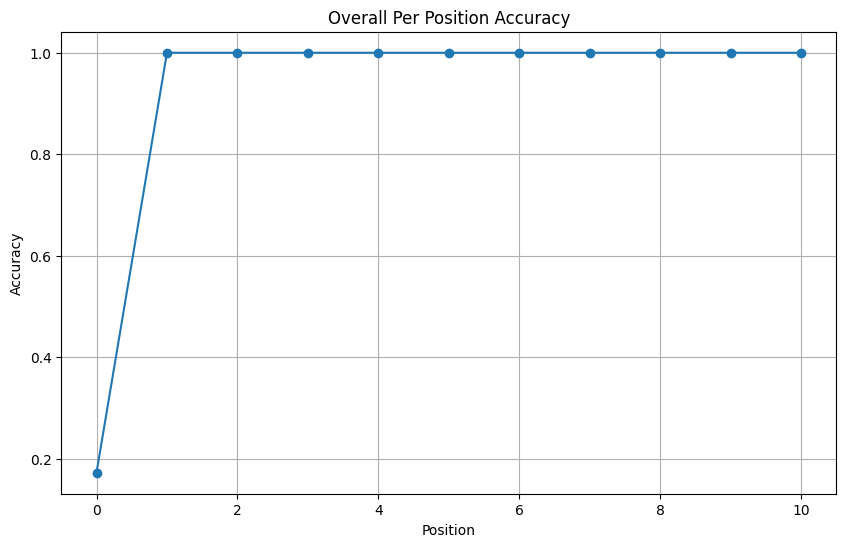

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9247691631317139       │
│     test_overall_seq_acc      │      0.17246094346046448      │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N2 R4 N5 <SEP> </CTX> <QUERY> N31 R0
Predicted: N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N45 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N10 R2 N22 <SEP> </CTX> <QUERY> N39 R0
Predicted: N44 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N48 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N3 R4 N20 <SEP> </CTX> <QUERY> N37 R4
Predicted: N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N39 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

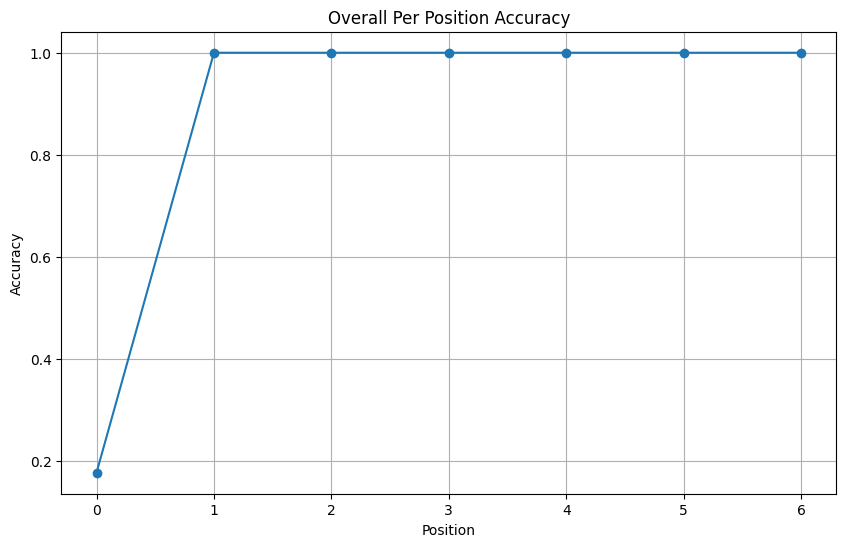

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.8824219107627869       │
│     test_overall_seq_acc      │      0.17695312201976776      │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N12 R0 N43 <SEP> N33 R1 N35 <SEP> </CTX> <QUERY> N10 R2
Predicted: N33 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N40 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N33 R0 N43 <SEP> N16 R0 N29 <SEP> </CTX> <QUERY> N5 R4
Predicted: N10 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N19 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N6 R3 N38 <SEP> N0 R2 N10 <SEP> </CTX> <QUERY> N6 R0
Predicted: N10 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N8 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

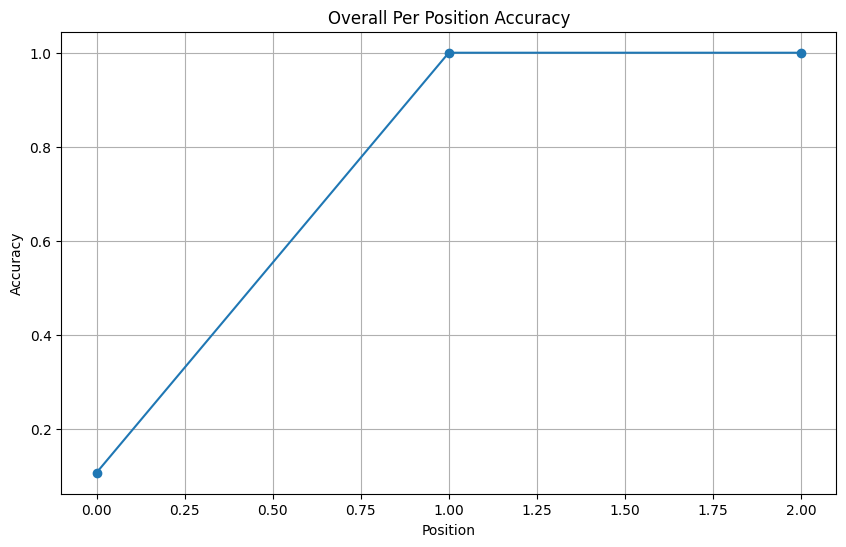

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.7024739384651184       │
│     test_overall_seq_acc      │          0.107421875          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N29 R4 N31 <SEP> N3 R0 N41 <SEP> N8 R2 N44 <SEP> </CTX> <QUERY> N3 R0
Predicted: N31 </QUERY> <EOS>
Target: N41 </QUERY> <EOS>

Input: <CTX> N14 R3 N15 <SEP> N29 R1 N44 <SEP> N47 R4 N44 <SEP> </CTX> <QUERY> N47 R4
Predicted: N30 </QUERY> <EOS>
Target: N44 </QUERY> <EOS>

Input: <CTX> N15 R4 N30 <SEP> N8 R2 N39 <SEP> N8 R3 N7 <SEP> </CTX> <QUERY> N8 R3
Predicted: N4 </QUERY> <EOS>
Target: N7 </QUERY> <EOS>



In [87]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

